# Stream Classification
---

## `NEWeather` dataset

**Description:** The National Oceanic and Atmospheric Administration (NOAA),
has compiled a database of weather measurements from over 7,000 weather 
stations worldwide. Records date back to the mid-1900s. Daily measurements
include a variety of features (temperature, pressure, wind speed, etc.) as
well as a series of indicators for precipitation and other weather-related
events. The `NEweather` dataset contains data from this database, specifically
from the Offutt Air Force Base in Bellevue, Nebraska ranging for over 50 years
(1949-1999).

**Features:** 8 Daily weather measurements
 
|       Attribute      | Description |
|:--------------------:|:-----------------------------|
| `temp`                   | Temperature
| `dew_pnt`                | Dew Point
| `sea_lvl_press`          | Sea Level Pressure
| `visibility`             | Visibility
| `avg_wind_spd`           | Average Wind Speed
| `max_sustained_wind_spd` | Maximum Sustained Wind Speed
| `max_temp`               | Maximum Temperature
| `min_temp`               | Minimum Temperature


**Class:** `rain` | 0: no rain, 1: rain
 
**Samples:** 18,159


In [1]:
import pandas as pd
from river.stream import iter_pandas
from river.metrics.base import Metrics
from river.utils import Rolling
from river.metrics import Accuracy,BalancedAccuracy,CohenKappa,GeometricMean
from river.evaluate import iter_progressive_val_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../datasets/NEweather.csv")
features = data.columns[:-1]

In [3]:
data.columns[-1]

'rain'

In this example, we load the data from a csv file with `pandas.read_csv`, and we use the [iter_pandas](https://riverml.xyz/0.21.2/api/stream/iter-pandas/) utility method to iterate over the `DataFrame`.

In [4]:
stream = iter_pandas(X=data[features], y=data['rain'])

In [5]:
# Function to plot the results
def plot_results(steps,plot_title,rolling):
    res = []
    for step in steps:
        if rolling:
            res.append([step['Rolling'].get()[0],step['Rolling'].get()[1],step['Rolling'].get()[2],step['Rolling'].get()[3]])
        else:
            res.append([step['Accuracy'].get(),step['BalancedAccuracy'].get(),step['GeometricMean'].get(),step['CohenKappa'].get()])
    fig = plt.figure()
    plt.plot(res, label=['Accuracy','BalancedAccuracy','GeometricMean','CohenKappa'])
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('Metrics', fontsize=13)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(plot_title)
    plt.show()
    

## Naïve Bayes
---
[GaussianNB](https://riverml.xyz/0.21.2/api/naive-bayes/GaussianNB/) maintains a Gaussian distribution $G_{cf}$ is maintained for each class $c$ and each feature $f$. Each Gaussian is updated using the amount associated with each feature; the details can be be found in proba.Gaussian. The joint log-likelihood is then obtained by summing the log probabilities of each feature associated with each class.
To plot the results, we use the [iter_progressive_val_score](https://riverml.xyz/0.21.2/api/evaluate/iter-progressive-val-score/) function. It works as the [progressive_val_score](https://riverml.xyz/0.21.2/api/evaluate/progressive-val-score/) but it returns the metrics results.

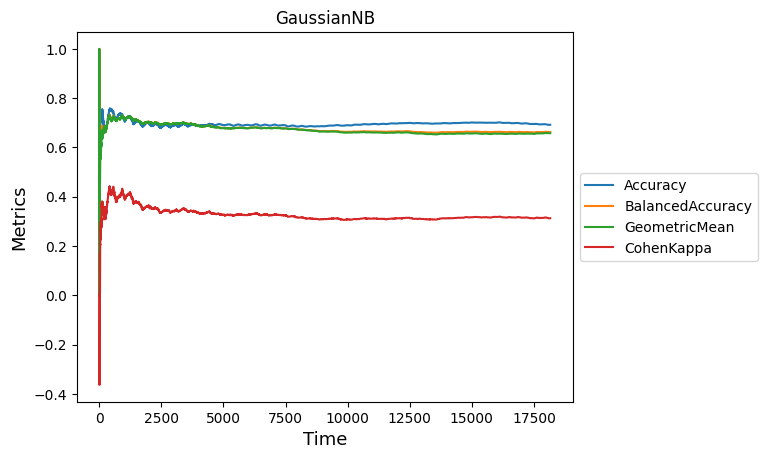

In [6]:
from river.naive_bayes import GaussianNB

model = GaussianNB()
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'GaussianNB',rolling=False)

## K-Nearest Neighbors
---
[KNN](https://riverml.xyz/0.21.2/api/neighbors/KNNClassifier/) is a non-parametric classification method that keeps track of the last window_size training samples. The predicted class-label for a given query sample is obtained in two steps:

- Find the closest n_neighbors to the query sample in the data window. 
- Aggregate the class-labels of the n_neighbors to define the predicted class for the query sample.

The strategy to perform search queries in the data buffer is defined by the `engine` parameter. In this example we use the Sliding WIndow-based Nearest Neighbor ([SWINN](https://riverml.xyz/0.21.2/api/neighbors/SWINN/)) search using Graphs.

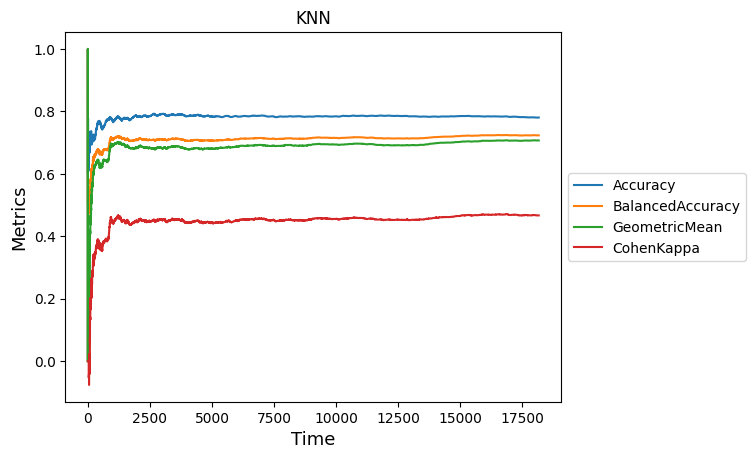

In [7]:
from river.neighbors import KNNClassifier,SWINN
import functools
from river import utils

l1_dist = functools.partial(utils.math.minkowski_distance, p=1)
model = KNNClassifier(n_neighbors=5, engine=SWINN(dist_func=l1_dist,seed=42,maxlen=1000))
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'KNN',rolling=False)

## Hoeffding Tree
---

[Hoeffding Tree](https://riverml.xyz/0.21.2/api/tree/HoeffdingTreeClassifier/) is a popular tree-based model due to its interpretability. It uses a tree data structure to model the data. When a sample arrives, it traverses the tree until it reaches a leaf node. Internal nodes define the path for a data sample based on the values of its features. Leaf nodes are models that provide predictions for unlabeled-samples and can update their internal state using the labels from labeled samples.

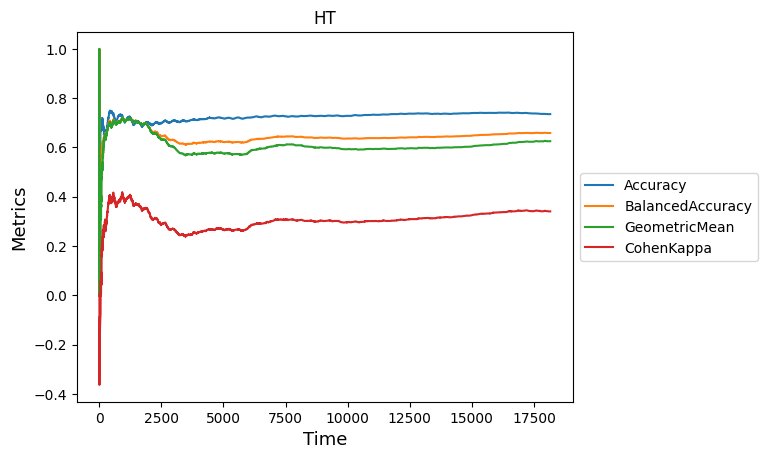

In [8]:
from river.tree import HoeffdingTreeClassifier

model = HoeffdingTreeClassifier()
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'HT',rolling=False)

## Hoeffding Adaptive Tree
---
The [HAT](https://riverml.xyz/0.21.2/api/tree/HoeffdingAdaptiveTreeClassifier/) model uses `ADWIN` to detect changes. If change is detected in a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

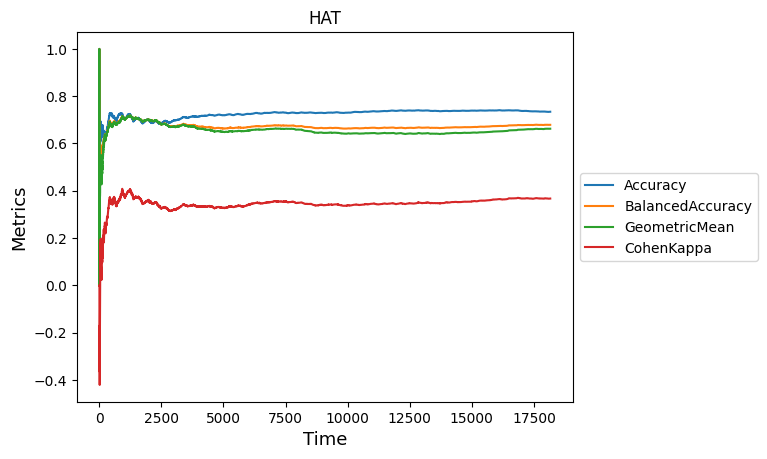

In [9]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'HAT',rolling=False)

## Concept Drift Impact

Concept drift can negatively impact learning methods if not properly handled. Multiple real-world applications suffer **model degradation** as the models can not adapt to changes in the data.

---
## `AGRAWAL` dataset

We will load the data from a csv file. The data was generated using the `AGRAWAL` data generator with 3 **gradual drifts** at the 5k, 10k, and 15k marks. It contains 9 features, 6 numeric and 3 categorical.

There are 10 functions for generating binary class labels from the features. These functions determine whether a **loan** should be approved.

| Feature    | Description            | Values                                                                |
|------------|------------------------|-----------------------------------------------------------------------|
| `salary`     | salary                 | uniformly distributed from 20k to 150k                                |
| `commission` | commission             | if (salary <   75k) then 0 else uniformly distributed from 10k to 75k |
| `age`        | age                    | uniformly distributed from 20 to 80                                   |
| `elevel`     | education level        | uniformly chosen from 0 to 4                                          |
| `car`        | car maker              | uniformly chosen from 1 to 20                                         |
| `zipcode`    | zip code of the town   | uniformly chosen from 0 to 8                                          |
| `hvalue`     | value of the house     | uniformly distributed from 50k x zipcode to 100k x zipcode            |
| `hyears`     | years house owned      | uniformly distributed from 1 to 30                                    |
| `loan`       | total loan amount      | uniformly distributed from 0 to 500k                                  |

**Class:** `y` | 0: no loan, 1: loan
 
**Samples:** 20,000

`elevel`, `car`, and `zipcode` are categorical features.

In [10]:
data = pd.read_csv("../datasets/agr_a_20k.csv")
features = data.columns[:-1]

Since there are several drifts, to better track the model behaviour, let's use a [Rolling Window](https://riverml.xyz/0.10.1/api/metrics/Rolling/) to compute the performance. It is a fixed size wrapper for computing metrics over a window. When the window is full, the oldest element is removed. In this way, the performance refers to the most recent data, possibly affected by a concept drift

## Naïve Bayes

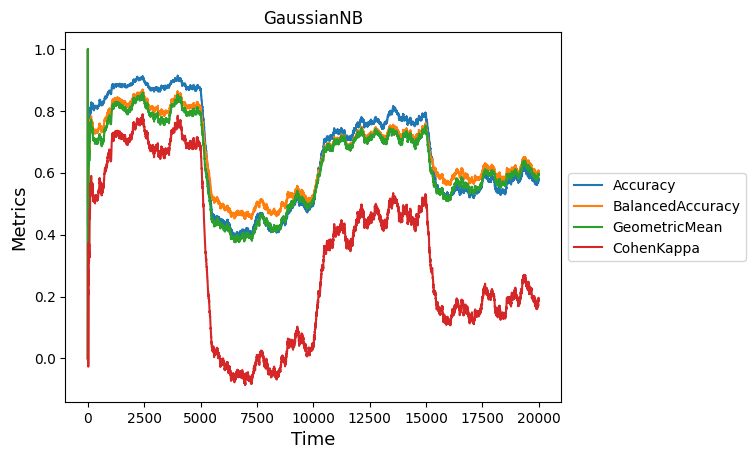

In [11]:
from river.naive_bayes import GaussianNB

model = GaussianNB()
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'GaussianNB',rolling=True)

## KNN

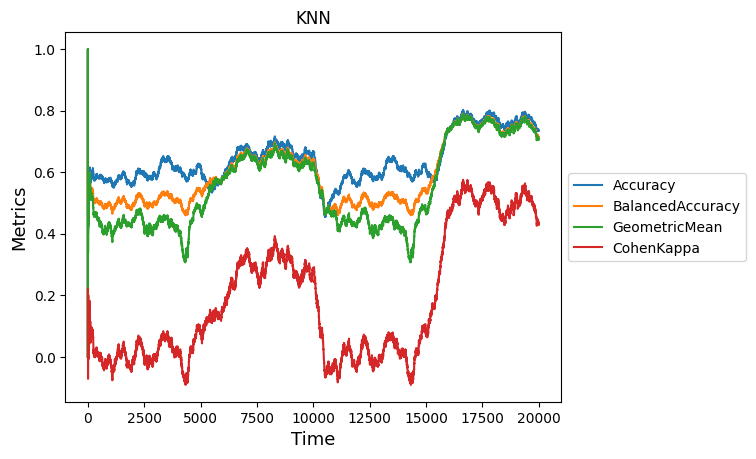

In [12]:
from river.neighbors import KNNClassifier,SWINN
import functools
from river import utils,compose

l1_dist = functools.partial(utils.math.minkowski_distance, p=1)
model = (
    compose.Discard('elevel', 'car', 'zipcode') |
    KNNClassifier(n_neighbors=5, engine=SWINN(dist_func=l1_dist,seed=42,maxlen=1000))
)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'KNN',rolling=True)

## Hoeffding Tree

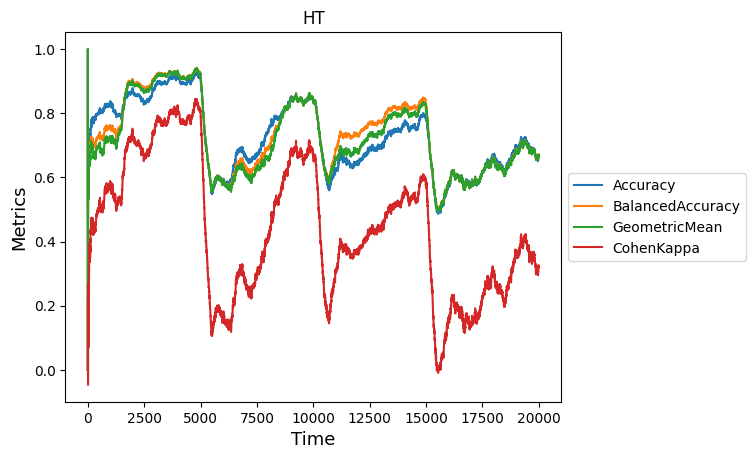

In [13]:
from river.tree import HoeffdingTreeClassifier

model = HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'])
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'HT',rolling=True)

## Hoeffding Adaptive Tree

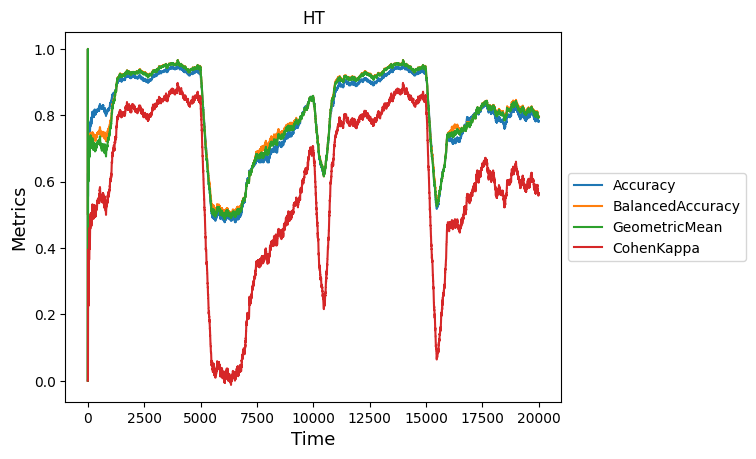

In [14]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'], seed=42)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)
plot_results(steps,'HT',rolling=True)